In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
tic_data = np.load('D:/UIUC/Project/Pickel_files/transform/tic_projection_concatenate.pkl.npy', mmap_mode=None, allow_pickle=False,fix_imports=True,encoding='ASCII')

label_data = np.load('D:/UIUC/Project/Pickel_files/label/five_trajectory_all_atom-02-07-24.pkl.npy', mmap_mode = None, allow_pickle=False, fix_imports=True, encoding= 'ASCII')

i_train, i_test, j_train, j_test = train_test_split(tic_data,label_data,test_size=0.20)

In [3]:
print(i_train.shape)
print(i_test.shape)
print(j_train.shape)
print(j_test.shape)

(20004, 280)
(5001, 280)
(20004, 94, 3)
(5001, 94, 3)


In [4]:
# converting the numpy training array into a tensor
data_train_tensor = torch.tensor(i_train, dtype = torch.float32)
# converting the label numpy array into atensor
label_train_tensor = torch.tensor(j_train, dtype = torch.float32)

data_test_tensor = torch.tensor(i_test, dtype = torch.float32)

label_test_tensor = torch.tensor(j_test, dtype = torch.float32)

In [5]:
input_size = 280
hidden_size1 = 200
hidden_size2 = 260
output = 282
epochs = 10
batch = 1000
learn = 0.001

In [6]:
class Cnn(nn.Module):
    def __init__ (self):
        super(Cnn,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=(1,3), padding=(0,1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(1,2), stride = 1),
            
            #nn.Conv2d(16, 32, kernel_size=(1,3), padding = (0,1)),
            #nn.ReLU(),
            #nn.BatchNorm2d(32),
            #nn.MaxPool2d(kernel_size=(1,2), stride = 1),

            #nn.Conv2d(32, 64, kernel_size=(1,3), padding = (0,1)),
            #nn.ReLU(),
            #nn.BatchNorm2d(64),
            #nn.MaxPool2d(kernel_size=(1,2), stride = 1),
        )

        
        self.fclayer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*279, 10000),
            nn.ReLU(),
            nn.Linear(10000,5000),
            nn.ReLU(),
            nn.Dropout(0.30),
            nn.Linear(5000,1000),
            nn.Sigmoid(),
            nn.Dropout(0.25),
            nn.Linear(1000,500),
            nn.Sigmoid(),
            nn.Linear(500,282)
            
        )

    def forward(self, x):
        #print("forward begin:",x.shape)
        x = x.view(x.size(0),1, 1, x.size(1))
        #print("after reshaping:", x.shape)
        x = self.conv1(x)
        #print("after conv:", x.shape)
        x = x.view(x.size(0), -1)
        x = self.fclayer(x)
        #print("after fclayer:", x.shape)
        x = x.view(x.size(0), 94, 3)
        return x

In [7]:
net = Cnn()
net

Cnn(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fclayer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8928, out_features=10000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10000, out_features=5000, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=5000, out_features=1000, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=1000, out_features=500, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=500, out_features=282, bias=True)
  )
)

In [8]:
optimizer = optim.Adam(net.parameters(), lr = learn)
Criterion = nn.MSELoss()

In [9]:
log_loss = []
for epoch in range(epochs):
    for i in range(0, data_train_tensor.shape[0], batch):
        train_mini = data_train_tensor[i:i+batch]
        label_mini = label_train_tensor[i:i+batch]
        optimizer.zero_grad()
        net_output = net(train_mini)
        loss = Criterion(net_output, label_mini)
        loss.backward()
        optimizer.step()

        if i%100 ==0:
            log_loss.append(loss.data.item())
    print('Epoch {}, Los: {}'.format(epoch +1, loss.data.item()))

Epoch 1, Los: 0.1197827085852623
Epoch 2, Los: 0.024321667850017548
Epoch 3, Los: 0.02028818614780903
Epoch 4, Los: 0.02046622894704342
Epoch 5, Los: 0.019851308315992355
Epoch 6, Los: 0.01949753612279892
Epoch 7, Los: 0.018383881077170372
Epoch 8, Los: 0.01801193878054619
Epoch 9, Los: 0.017841912806034088
Epoch 10, Los: 0.01760953478515148


Text(0.5, 1.0, 'MSELoss of Training Data')

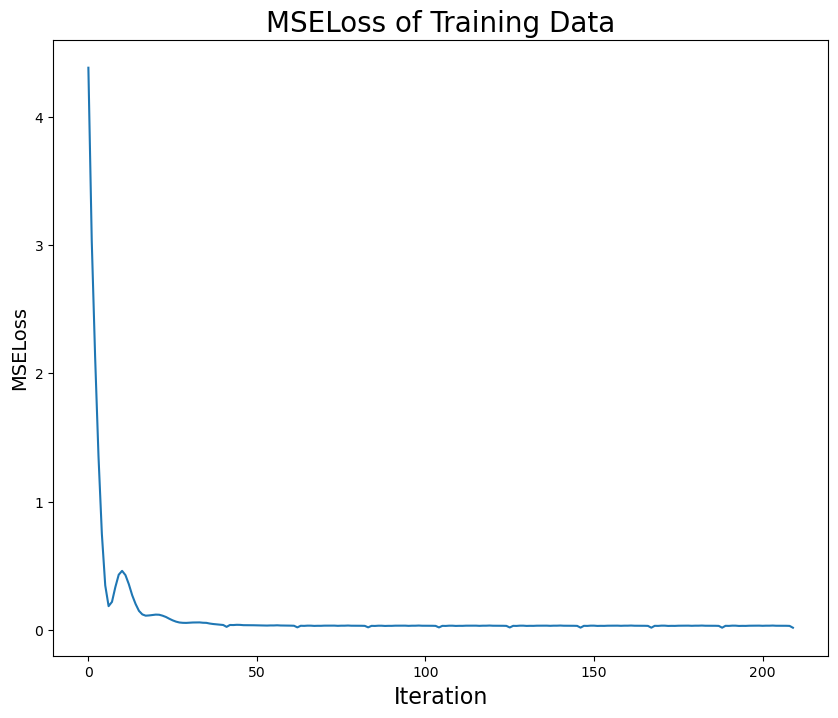

In [10]:
plt.figure(figsize=(10,8))
plt.plot(log_loss[:])
plt.xlabel('Iteration', fontsize = 16)
plt.ylabel('MSELoss', fontsize = 14)
plt.title('MSELoss of Training Data', fontsize = 20)
#plt.savefig('plots/MSELoss.png',dpi = 400)

In [11]:
# test workne.eval()
net.eval()
test_pred = net(data_test_tensor)

In [12]:
label_test_tensor

tensor([[[1.9890, 2.1670, 2.5350],
         [1.9000, 2.1430, 2.5750],
         [2.0480, 2.0870, 2.5320],
         ...,
         [1.6010, 1.3200, 2.2380],
         [1.6760, 1.4320, 2.0560],
         [1.7040, 1.5200, 2.0300]],

        [[1.9880, 2.2370, 2.4620],
         [1.9680, 2.3300, 2.4940],
         [2.0830, 2.2070, 2.4690],
         ...,
         [1.7250, 1.4410, 2.0060],
         [1.5320, 1.3750, 2.1020],
         [1.5320, 1.3200, 2.0230]],

        [[2.1700, 2.1610, 2.2960],
         [2.2030, 2.2550, 2.2850],
         [2.2330, 2.1010, 2.3460],
         ...,
         [1.6110, 1.3970, 2.0930],
         [1.7180, 1.5660, 1.9950],
         [1.7350, 1.6590, 2.0160]],

        ...,

        [[2.1460, 2.2860, 2.3110],
         [2.0770, 2.3480, 2.2720],
         [2.2200, 2.3220, 2.3690],
         ...,
         [1.5460, 1.4450, 2.1760],
         [1.6100, 1.6320, 2.0710],
         [1.6670, 1.7080, 2.0860]],

        [[2.0380, 2.1010, 2.3830],
         [2.0710, 2.1860, 2.3390],
         [2.

In [13]:
test_pred

tensor([[[1.9869, 2.1895, 2.2783],
         [2.0075, 2.2088, 2.2838],
         [2.0134, 2.1867, 2.2881],
         ...,
         [1.6458, 1.4512, 2.1352],
         [1.6504, 1.4304, 2.1534],
         [1.6299, 1.3968, 2.1018]],

        [[1.9869, 2.1895, 2.2783],
         [2.0075, 2.2088, 2.2838],
         [2.0134, 2.1867, 2.2881],
         ...,
         [1.6458, 1.4512, 2.1352],
         [1.6504, 1.4304, 2.1534],
         [1.6299, 1.3968, 2.1018]],

        [[1.9869, 2.1895, 2.2783],
         [2.0075, 2.2088, 2.2838],
         [2.0134, 2.1867, 2.2881],
         ...,
         [1.6458, 1.4512, 2.1352],
         [1.6504, 1.4304, 2.1534],
         [1.6299, 1.3968, 2.1018]],

        ...,

        [[1.9869, 2.1895, 2.2783],
         [2.0075, 2.2088, 2.2838],
         [2.0134, 2.1867, 2.2881],
         ...,
         [1.6458, 1.4512, 2.1352],
         [1.6504, 1.4304, 2.1534],
         [1.6299, 1.3968, 2.1018]],

        [[1.9869, 2.1895, 2.2783],
         [2.0075, 2.2088, 2.2838],
         [2.

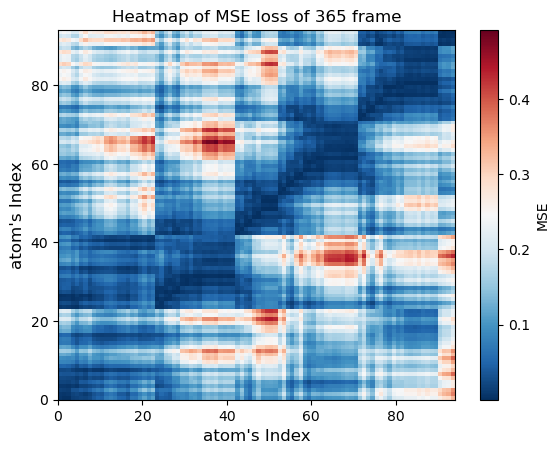

In [14]:
idx = 365

actual_frame = label_test_tensor[idx].detach().numpy()  
predicted_frame = test_pred[idx].detach().numpy()      


#mse_frame = np.mean((actual_frame - predicted_frame) ** 2, axis=1)  

similarity_matrix = np.zeros((94, 94))
for i in range(94):
    for j in range(94):
        mse = np.mean(np.square(actual_frame[i] - predicted_frame[j]))
        similarity_matrix[i,j] = mse

cmap = plt.cm.RdBu_r
fig, ax = plt.subplots()
heatmap = ax.pcolormesh(similarity_matrix, cmap = cmap)
fig.colorbar(heatmap, label="MSE")
plt.title("Heatmap of MSE loss of {} frame".format(idx))
plt.xlabel("atom's Index",fontsize = 12)
plt.ylabel("atom's Index", fontsize = 12)
#plt.savefig('plots/Heatmap of MSE loss for frame 1000.png', dpi = 400)
plt.show()

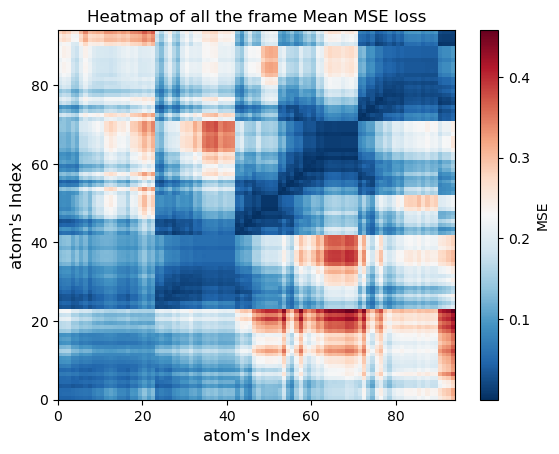

In [15]:
actual_frame = label_test_tensor.detach().numpy()
predicted_frame = test_pred.detach().numpy()

def matrix(act, pre):
    sm_mat = np.zeros((94,94))
    for i in range(94):
        for j in range(94):
            mse = np.mean(np.square(act[i] - pre[j]))
            sm_mat[i, j] = mse

    return sm_mat

empty_list = []
for iter in range(label_test_tensor.shape[0]):
    x = matrix(actual_frame[iter], predicted_frame[iter])
    empty_list.append(x)

Mean_of_all_frame = np.mean(empty_list, axis=0)

cmap = plt.cm.RdBu_r
fig, ax = plt.subplots()
heatmap = ax.pcolormesh(Mean_of_all_frame, cmap = cmap)
fig.colorbar(heatmap, label="MSE")
plt.title("Heatmap of all the frame Mean MSE loss")
plt.xlabel("atom's Index",fontsize = 12)
plt.ylabel("atom's Index", fontsize = 12)
#plt.savefig('plots/Heatmap of MSE loss for all frame.png', dpi = 400)
plt.show()